
# ** PREDICTING ROAD ACCIDENTS RISK - REGRESSION PROBLEM **

# Introduction

> This data science project is a part of https://www.kaggle.com/competitions/playground-series-s5e10 .It aims to predict road accident risk by applying machine learning methods. The objective is to predict risk level of road by analyzing their factors. The project invoves preprocessing ,categorical encoding the train and test data , and apply regression machine learning models such as linear regression,decision tree regressor, random forest regressor and xgb regressor. After that choose the best model to predict and test it on test data for final submission.
>
> In the version 6 ,i maked cross_val_score and hyperparameter tuning sections as markdown section for fast execution of programs 

# Loading the Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint,uniform
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

# Read the Dataset

In [2]:
train= pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')
test= pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')

# Check the Data

In [3]:
train.shape

(517754, 14)

In [4]:
test.shape

(172585, 13)

## Glimpse the Data

In [5]:
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [6]:
test.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


## Check missing values

In [7]:
train.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

> There is no missing values in the train dataset

In [8]:
train.duplicated().sum()

0

> There is no duplicated values in the dataset. That means the dataset is clean

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

## Data unbalance

> Here the target variable is accident_risk . To check target distribution ,plot histogram

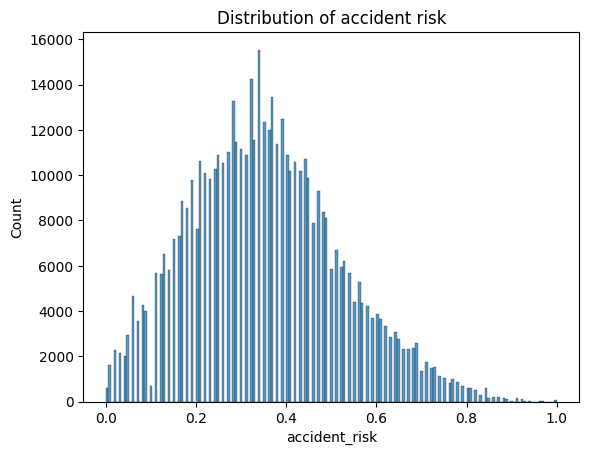

In [10]:
sns.histplot(x='accident_risk',data=train)
plt.title('Distribution of accident risk')
plt.show()

> The histplot is normal bell shaped structure and right skewed. It have long tail near 1.0 showing outliers.it can distroy the training  

In [11]:
train['accident_risk'].skew()

0.37841797634228086

> That means it is not heavily skewed.

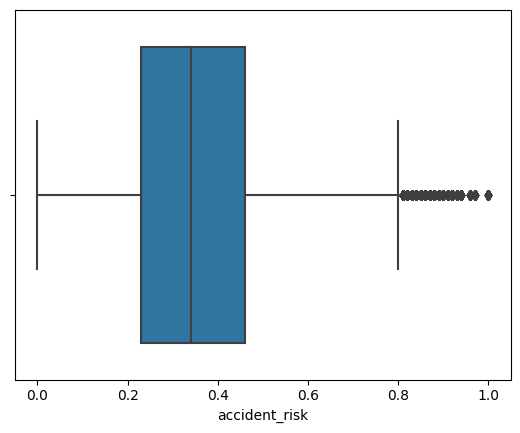

In [12]:
sns.boxplot(x='accident_risk',data=train)
plt.show()

# Data Exploration

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

> There are booliean columns which have true/false values and we want to convert into 1/0 using map function.

In [14]:
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for col in bool_cols:
    train[col] = train[col].map({True: 1, False: 0}) 
    test[col] = test[col].map({True: 1, False: 0}) 

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  int64  
 8   public_road             517754 non-null  int64  
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  int64  
 11  school_season           517754 non-null  int64  
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: float64(2), int64

In [15]:
train.nunique()

id                        517754
road_type                      3
num_lanes                      4
curvature                    261
speed_limit                    5
lighting                       3
weather                        3
road_signs_present             2
public_road                    2
time_of_day                    3
holiday                        2
school_season                  2
num_reported_accidents         8
accident_risk                 98
dtype: int64

> only 'curvature' have exactly numerical feature although others have numeric values with categorical features

## Univariate Analysis

### Explore Categorical features


road_type value_counts:
road_type
highway    173672
rural      172719
urban      171363
Name: count, dtype: int64


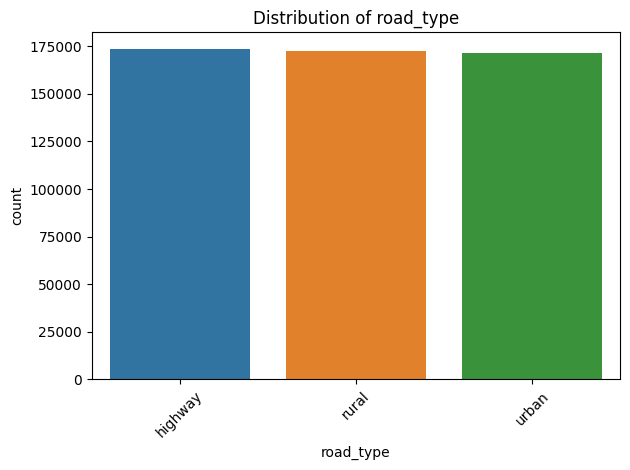


num_lanes value_counts:
num_lanes
1    131168
2    130054
4    129118
3    127414
Name: count, dtype: int64


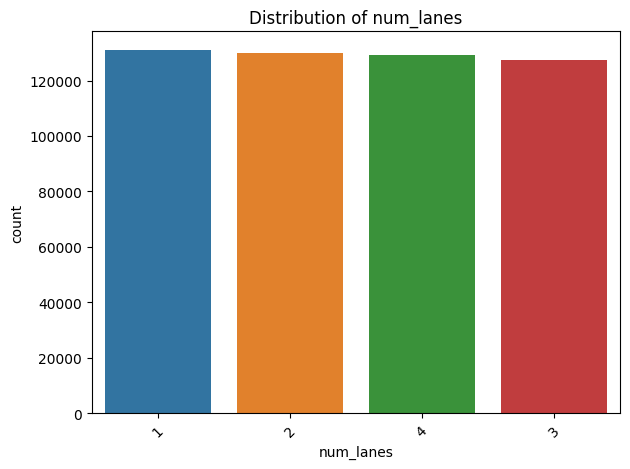


speed_limit value_counts:
speed_limit
45    115752
35    111628
25    101422
60    100304
70     88648
Name: count, dtype: int64


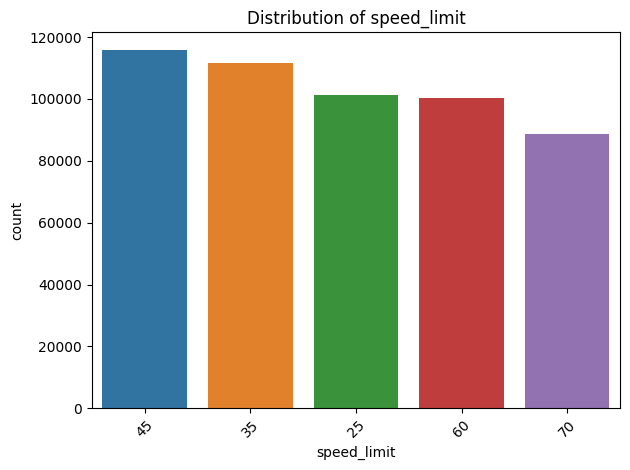


lighting value_counts:
lighting
dim         183826
daylight    178015
night       155913
Name: count, dtype: int64


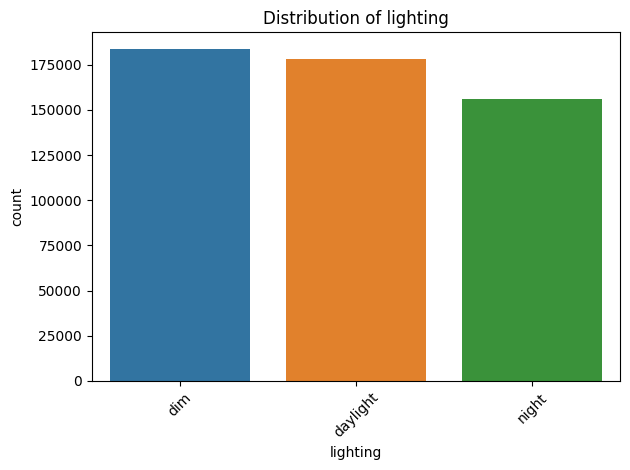


weather value_counts:
weather
foggy    181463
clear    179306
rainy    156985
Name: count, dtype: int64


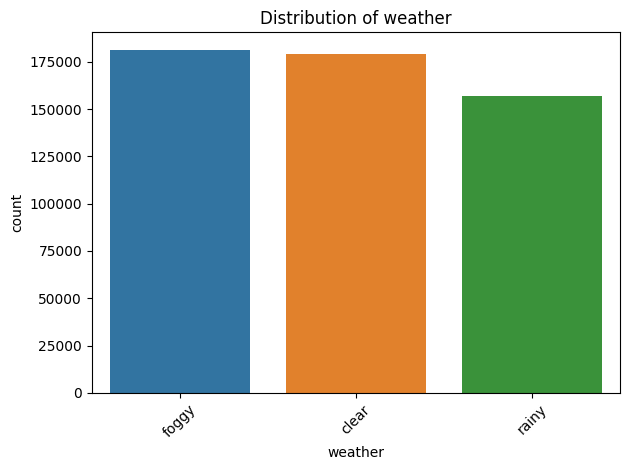


road_signs_present value_counts:
road_signs_present
0    259289
1    258465
Name: count, dtype: int64


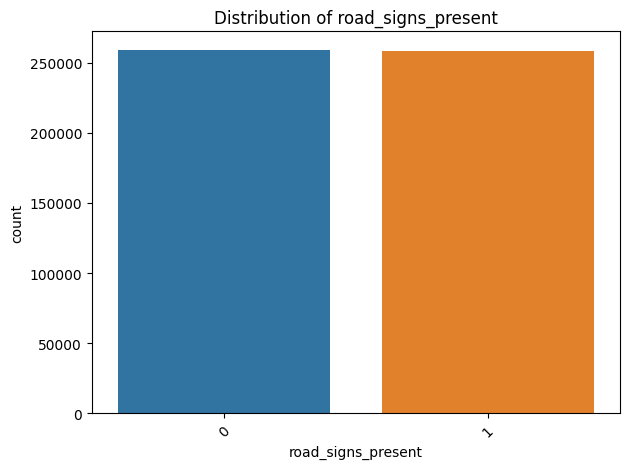


public_road value_counts:
public_road
1    260045
0    257709
Name: count, dtype: int64


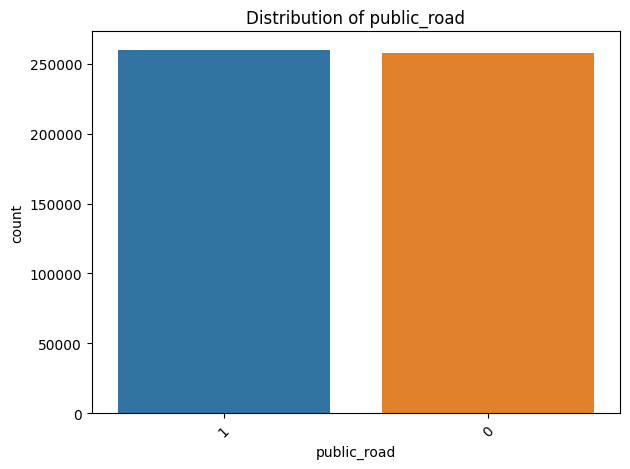


time_of_day value_counts:
time_of_day
morning      173410
evening      172837
afternoon    171507
Name: count, dtype: int64


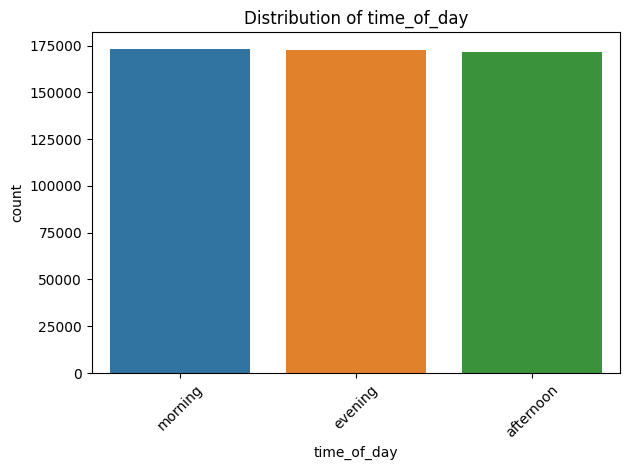


holiday value_counts:
holiday
1    260688
0    257066
Name: count, dtype: int64


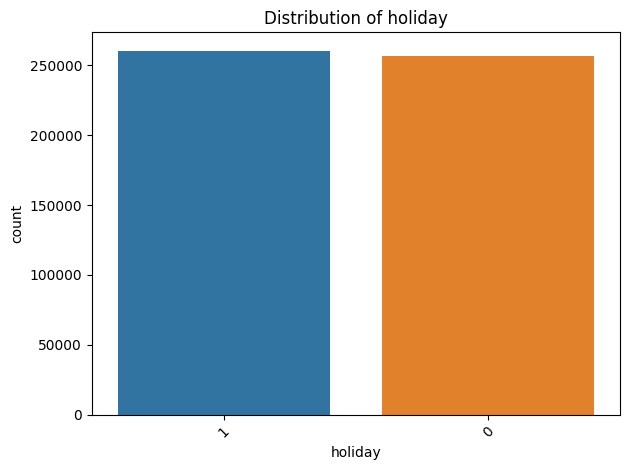


school_season value_counts:
school_season
0    260164
1    257590
Name: count, dtype: int64


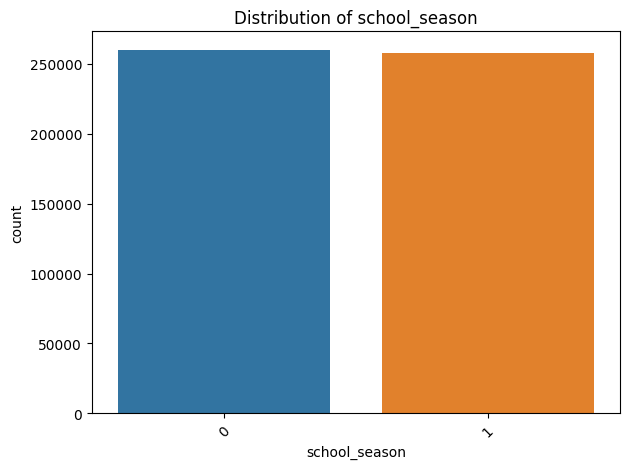


num_reported_accidents value_counts:
num_reported_accidents
1    209674
2    145965
0    125269
3     34197
4      2392
5       231
6        24
7         2
Name: count, dtype: int64


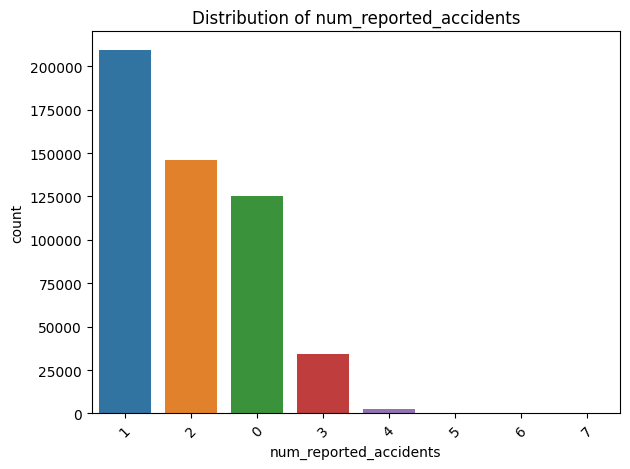

In [16]:
cat_cols=['road_type','num_lanes','speed_limit','lighting','weather','road_signs_present',
          'public_road','time_of_day','holiday','school_season','num_reported_accidents']

for col in cat_cols:
    print(f"\n{col} value_counts:")
    print(train[col].value_counts())
    sns.countplot(data=train, x=col, order=train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Explore numerical features

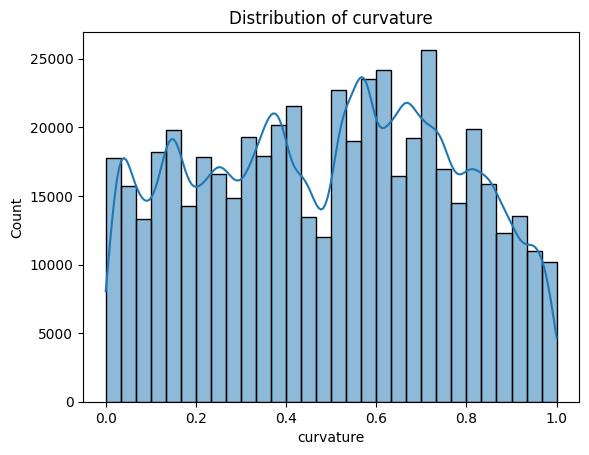

In [17]:
sns.histplot(train['curvature'], kde=True, bins=30)
plt.title(f'Distribution of curvature')
plt.show()

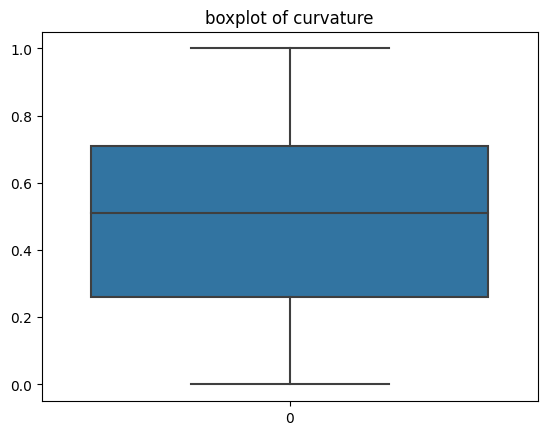

In [18]:
sns.boxplot(train['curvature'])
plt.title(f'boxplot of curvature')
plt.show()

## Bivariate analysis

### Numerical vs numerical

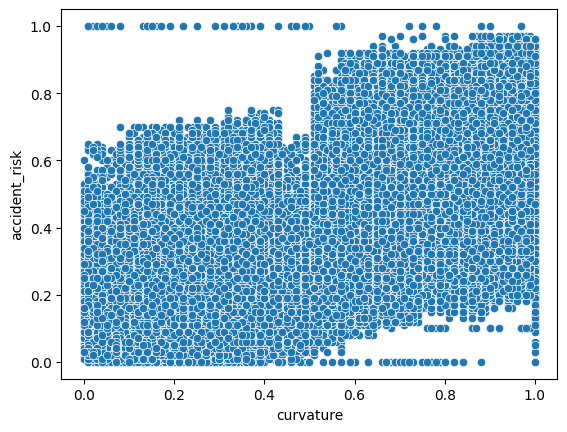

In [19]:
sns.scatterplot(x='curvature',y='accident_risk',data=train)
plt.show()

### categorical vs numerical

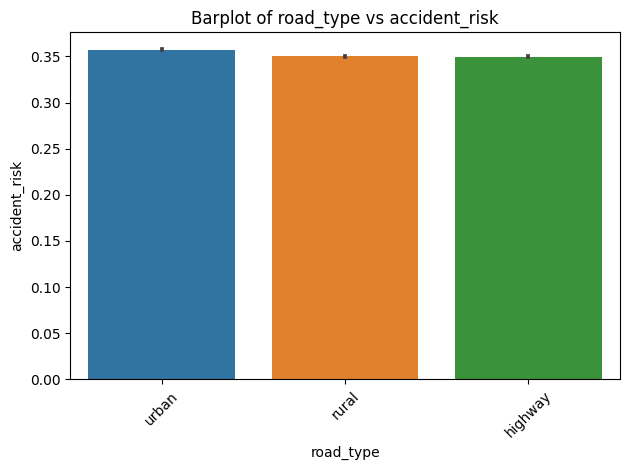

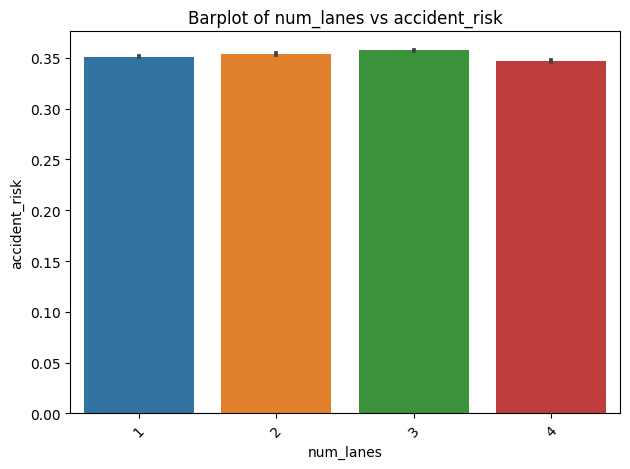

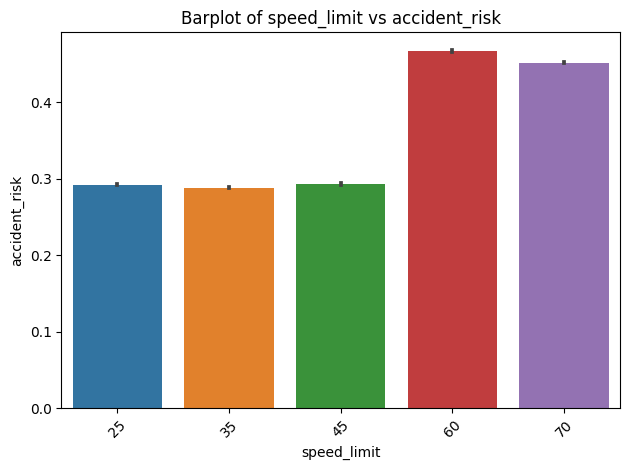

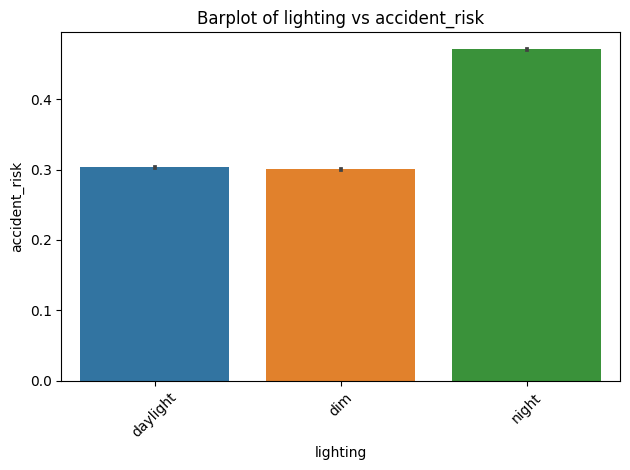

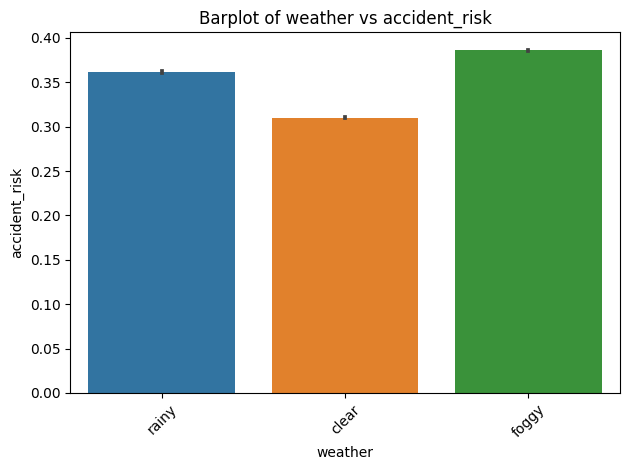

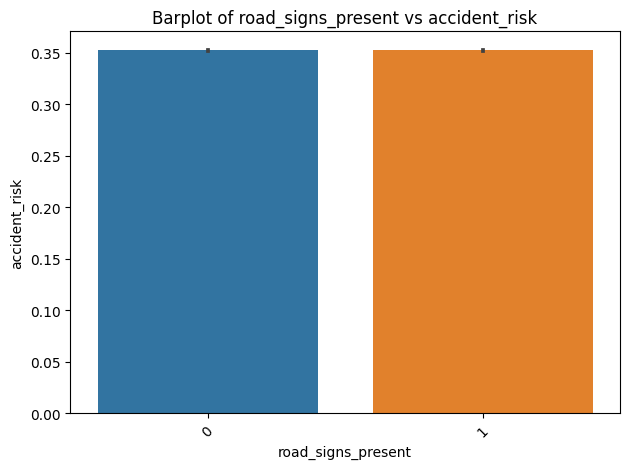

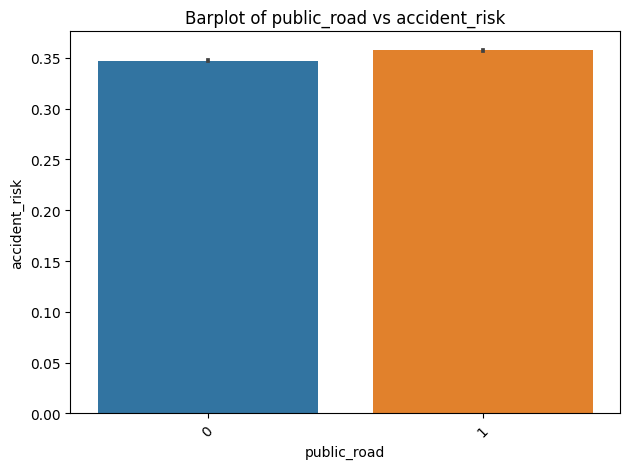

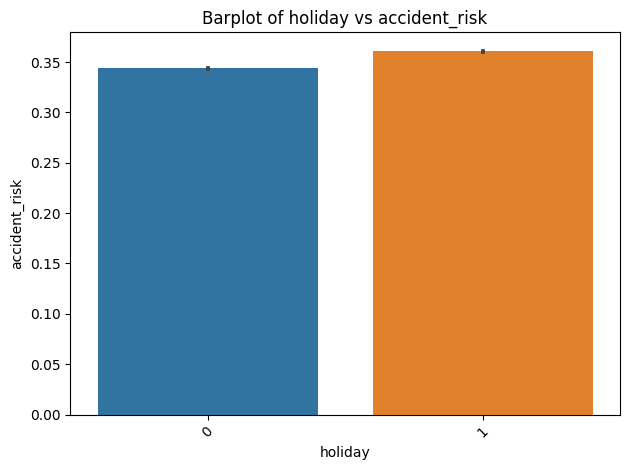

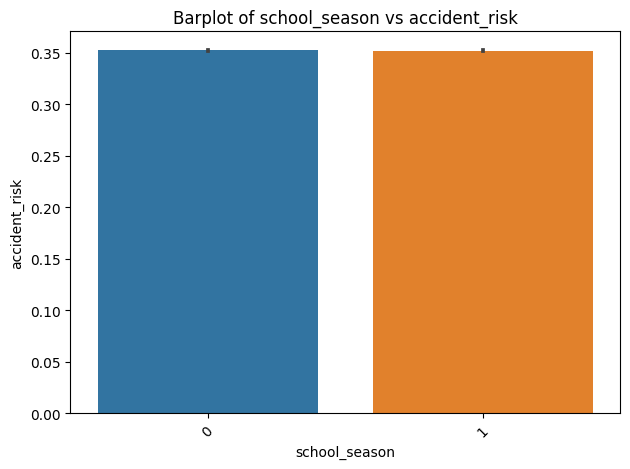

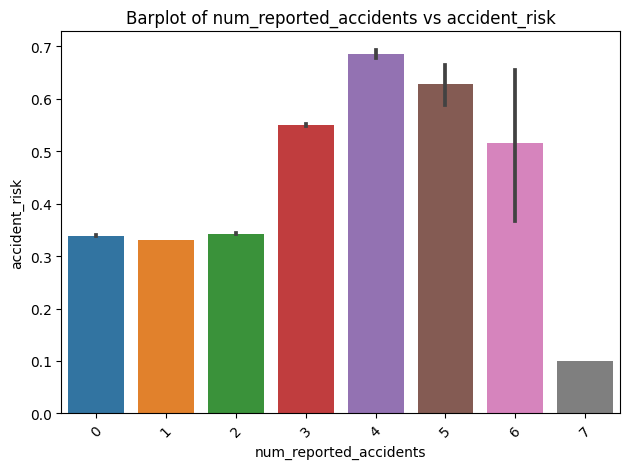

In [20]:
cat_cols=['road_type','num_lanes','speed_limit','lighting','weather','road_signs_present',
          'public_road','holiday','school_season','num_reported_accidents']

for col in cat_cols:
    sns.barplot(data=train, x=col, y='accident_risk')
    plt.title(f'Barplot of {col} vs accident_risk')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

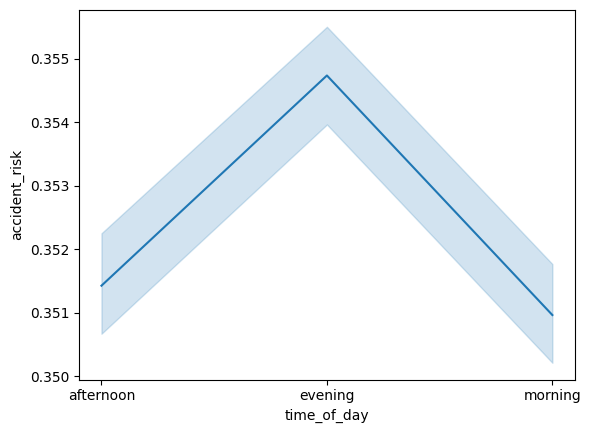

In [21]:
sns.lineplot(x='time_of_day',y='accident_risk',data=train)
plt.show()

## correlation

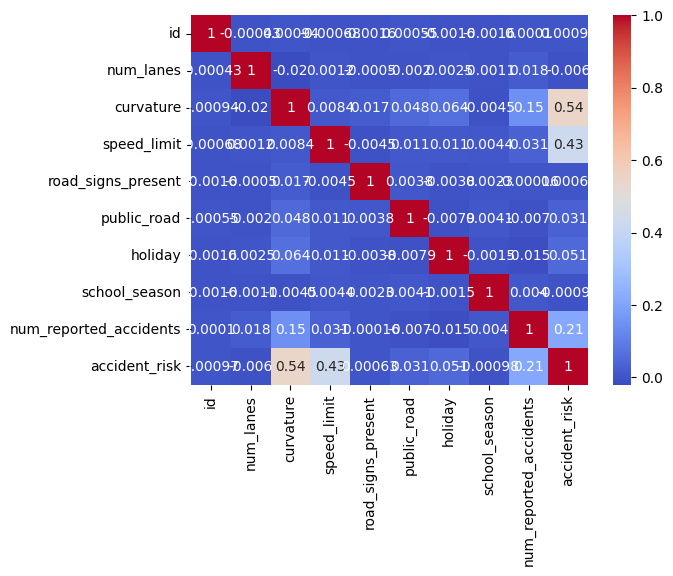

In [22]:
sns.heatmap(train.corr(numeric_only=True),annot=True,cmap='coolwarm')
plt.show()

# Predictive models

## categorical encodding

In [23]:
ohe=OneHotEncoder(drop='first', handle_unknown='ignore')
cat_cols=train.select_dtypes(include='object').columns.tolist()
encoded_data=ohe.fit_transform(train[cat_cols]).toarray()
encoded=pd.DataFrame(encoded_data,columns=ohe.get_feature_names_out(cat_cols))
train_numeric=train.drop(columns=cat_cols)
train=pd.concat([train_numeric.reset_index(drop=True),
                       encoded.reset_index(drop=True)],axis=1)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   num_lanes               517754 non-null  int64  
 2   curvature               517754 non-null  float64
 3   speed_limit             517754 non-null  int64  
 4   road_signs_present      517754 non-null  int64  
 5   public_road             517754 non-null  int64  
 6   holiday                 517754 non-null  int64  
 7   school_season           517754 non-null  int64  
 8   num_reported_accidents  517754 non-null  int64  
 9   accident_risk           517754 non-null  float64
 10  road_type_rural         517754 non-null  float64
 11  road_type_urban         517754 non-null  float64
 12  lighting_dim            517754 non-null  float64
 13  lighting_night          517754 non-null  float64
 14  weather_foggy       

## Define Predictors and target values

In [25]:
X=train.drop(columns=['id','accident_risk'],axis=1)
y=train['accident_risk']

In [26]:
scaler=StandardScaler()
X_cols=X.columns
X=scaler.fit_transform(X)
X = pd.DataFrame(X, columns=X_cols)

## Split Data in train,test and validation set

In [27]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=10)

## Comparison of models

models=[LinearRegression(),   
        DecisionTreeRegressor(),    
        RandomForestRegressor(),    
        XGBRegressor()]    
for model in models:    
    scores=cross_val_score(model,X,y,cv=5,scoring='neg_root_mean_squared_error')    
    cv_rmse=scores.mean()    
    print(f"Average CV RMSE for {model.__class__.__name__}: {cv_rmse:.4f}")    
    
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE of {model.__class__.__name__}: {rmse}")

Average CV RMSE for LinearRegression: -0.0735    
RMSE of LinearRegression: 0.07343286792605436    
Average CV RMSE for DecisionTreeRegressor: -0.0831    
RMSE of DecisionTreeRegressor: 0.083022130572676    
Average CV RMSE for RandomForestRegressor: -0.0595   
RMSE of RandomForestRegressor: 0.05931964103321271    
Average CV RMSE for XGBRegressor: -0.0562    
RMSE of XGBRegressor: 0.056174869479945565    

> Lower RMSE is the best model that means XGBRegressor.now finalizing the model with XGBREgressor

## Hyperparameter tuning

params = {
    'n_estimators': randint(100,300),
    'learning_rate': uniform(0.01,0.2) ,
    'max_depth': randint(3,10),
    'subsample': uniform(0.6,0.4),
    'colsample_bytree': uniform(0.6,0.4),
}

xgb = XGBRegressor(random_state=42)
search = RandomizedSearchCV(xgb, params, cv=5, scoring='neg_root_mean_squared_error', n_iter=30, verbose=1, n_jobs=-1)
search.fit(X, y)

print("Best Parameters:", search.best_params_)
print("Best CV RMSE:", -search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'colsample_bytree': 0.6838099738429964, 'learning_rate': 0.08552907855410101, 'max_depth': 7, 'n_estimators': 262, 'subsample': 0.9513205424771735}
Best CV RMSE: 0.05611825146180351

In [28]:
best_params = {
    'colsample_bytree': 0.6838099738429964,
    'learning_rate': 0.08552907855410101,
    'max_depth': 7, 
    'n_estimators': 262,
    'subsample': 0.9513205424771735,
    'random_state': 10
}

xgb=XGBRegressor(**best_params)
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE : {rmse}")

RMSE : 0.05610232566245935


# Submission

## Final Model-XGBRgressor

In [29]:
xgb.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6838099738429964, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.08552907855410101, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=262, n_jobs=None,
             num_parallel_tree=None, random_state=10, ...)

## feature importance

<Figure size 800x600 with 0 Axes>

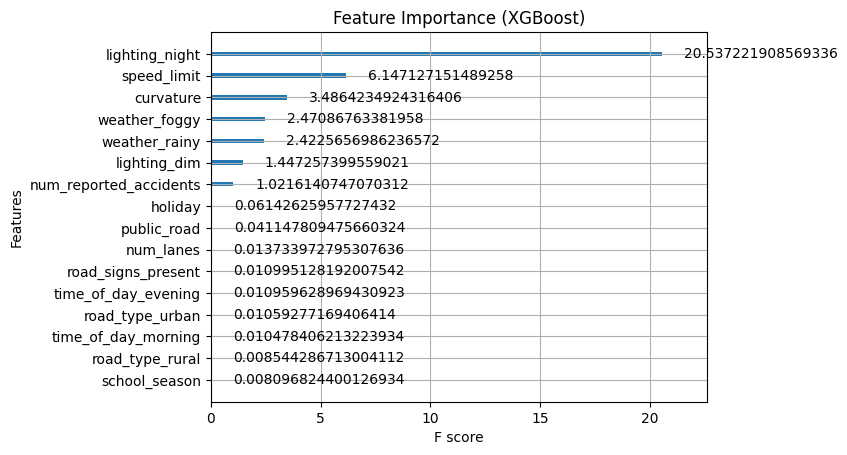

In [30]:
plt.figure(figsize=(8,6))
plot_importance(xgb, importance_type='gain')
plt.title('Feature Importance (XGBoost)')
plt.show()

# Predict on Test Data 

In [31]:
cat_cols=test.select_dtypes(include='object').columns.tolist()
encoded_data=ohe.fit_transform(test[cat_cols]).toarray()
encoded_test=pd.DataFrame(encoded_data,columns=ohe.get_feature_names_out(cat_cols))
test_numeric=test.drop(columns=cat_cols)
test=pd.concat([test_numeric.reset_index(drop=True),
                       encoded_test.reset_index(drop=True)],axis=1)

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172585 entries, 0 to 172584
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      172585 non-null  int64  
 1   num_lanes               172585 non-null  int64  
 2   curvature               172585 non-null  float64
 3   speed_limit             172585 non-null  int64  
 4   road_signs_present      172585 non-null  int64  
 5   public_road             172585 non-null  int64  
 6   holiday                 172585 non-null  int64  
 7   school_season           172585 non-null  int64  
 8   num_reported_accidents  172585 non-null  int64  
 9   road_type_rural         172585 non-null  float64
 10  road_type_urban         172585 non-null  float64
 11  lighting_dim            172585 non-null  float64
 12  lighting_night          172585 non-null  float64
 13  weather_foggy           172585 non-null  float64
 14  weather_rainy       

In [33]:
test_ids = test['id'].copy()

test_model = test.drop(columns=['id'], errors='ignore') 
test_model = pd.DataFrame(scaler.transform(test_model), columns=X_cols)
test_model = test_model.reindex(columns=X.columns, fill_value=0)

y_pred = xgb.predict(test_model)

submission = pd.DataFrame({
    'id': test_ids,
    'accident_risk': y_pred
})

submission.to_csv('submission.csv', index=False)
print("Submission file created!")

Submission file created!
